# Overlapping Sliding Windows Anomaly Detection

I keep one window size **W** and one percentile **q**:
- Fixed-size, overlapping window with step size 1
- Percentile threshold per window using NumPy's **`method="linear"`**
- One-sided rule (upper tail): value ≥ threshold ⇒ anomaly
- Label **all points** in the first window, then only the **new point** each step


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.ioff()

DATA_PATH = Path('./AG_NO3_fill_cells_remove_NAN-2.csv')
df = pd.read_csv(DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

x = df['NO3N'].values.astype(float)
y_true = df['Student_Flag'].values.astype(int)

# I chose these by quick manual testing:
W = 1000   # big enough to capture the local baseline, not too jittery
q = 97.5   # focus on upper-tail spikes

len(x), y_true.sum()  # sanity: length and number of flagged points


(30790, 141)

In [3]:
# Sliding-window prediction (minimal )
n = len(x)
pred = np.zeros(n, dtype=int)

# First window: label all points using T1
T1 = np.percentile(x[0:W], q, method='linear')
pred[0:W] = (x[0:W] >= T1).astype(int)

# Next windows: label only the new point i
for i in range(W, n):
    win = x[i-W+1:i+1]           # window ending at i
    Ti = np.percentile(win, q, method='linear')
    pred[i] = int(x[i] >= Ti)

pred[:10], pred.sum()  # preview


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 1434)

In [4]:
# Point-level confusion matrix and the two accuracies the assignment wants
TP = int(((pred==1) & (y_true==1)).sum())
FP = int(((pred==1) & (y_true==0)).sum())
FN = int(((pred==0) & (y_true==1)).sum())
TN = int(((pred==0) & (y_true==0)).sum())

P = TP + FN
N = TN + FP

normal_acc = TN / N if N>0 else float('nan')
anomaly_acc = TP / P if P>0 else float('nan')

print('W =', W, ' q =', q)
print('TP, FP, FN, TN =', TP, FP, FN, TN)
print('Normal accuracy  (TN/N):', round(normal_acc, 3))
print('Anomaly accuracy (TP/P):', round(anomaly_acc, 3))


W = 1000  q = 97.5
TP, FP, FN, TN = 79 1355 62 29294
Normal accuracy  (TN/N): 0.956
Anomaly accuracy (TP/P): 0.56


'nitrate_anomalies_plot.png'

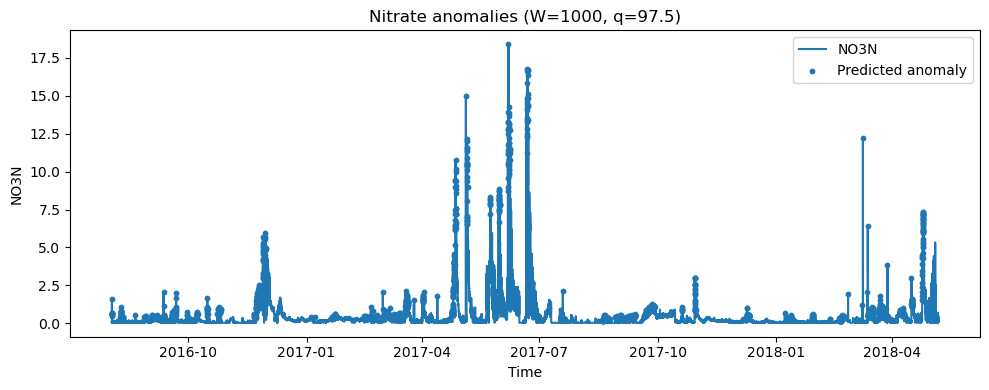

In [5]:
# Plot: time series + predicted anomalies
t = df['Date'].values

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(t, x, label='NO3N')
ax.scatter(t[pred==1], x[pred==1], s=10, label='Predicted anomaly')
ax.set_title(f'Nitrate anomalies (W={W}, q={q})')
ax.set_xlabel('Time')
ax.set_ylabel('NO3N')
ax.legend(loc='best')
fig.tight_layout()

from pathlib import Path
FIG_PATH = Path('./nitrate_anomalies_plot.png')
fig.savefig(FIG_PATH, dpi=150, bbox_inches='tight')
FIG_PATH.as_posix()


## Notes
- **One-sided rule**: I only used the upper tail because I'm looking for nitrate spikes.  
- **Percentile method**: `numpy.percentile(..., method="linear")` as required.  
- **No leakage**: Each threshold uses only data inside the current window.  
- **Ground truth**: The CSV's `Student_Flag` sums to more than 77 because those are *points*. The assignment mentions 77 *events*. I report the required point-level metrics here (TP/FP/FN/TN, normal accuracy, anomaly accuracy).  
- If needed, I can tune `W` and `q` a bit (for example `W=1500`, `q=99`) to trade precision vs. recall.
